In [1]:
import sys
import os
import json
sys.path.append("..")

import torch
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.pinns import PINN, SA_PINN, DB_PINN, PirateNetPINN, BasePINN
from models.base_models import ResNet
from models.losses import DWA_Loss
from models.utils.schedulers import LambdaScheduler
from common.train_functions import *
from common.plotting import *

import seaborn as sns

# Init

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
def save_eval_losses(eval_losses, filename):
    with open(filename, 'w') as f:
        json.dump(eval_losses, f)

def save_u_results(T, X, U, filename):
    with open(filename, 'w') as f:
        json.dump({
            "t_map": T.tolist(), "x_map": X.tolist(), "u_map": U.tolist()
        }, f)

def save_model(model, filename):
    """Save the model's state dictionary to a file."""
    torch.save(model.cpu().state_dict(), filename)

In [4]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
viscosity = 0.01 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [7]:
# Set number of data points
N_0 = 500
N_b = 500
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [8]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

sobol_sampler = qmc.Sobol(d=2, scramble=True)
X_r = sobol_sampler.random(n=N_r)
X_r = torch.tensor(qmc.scale(X_r, lb, ub), dtype=torch.float32, requires_grad=True)
t_r = X_r[:, 0:1]
x_r = X_r[:, 1:]

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

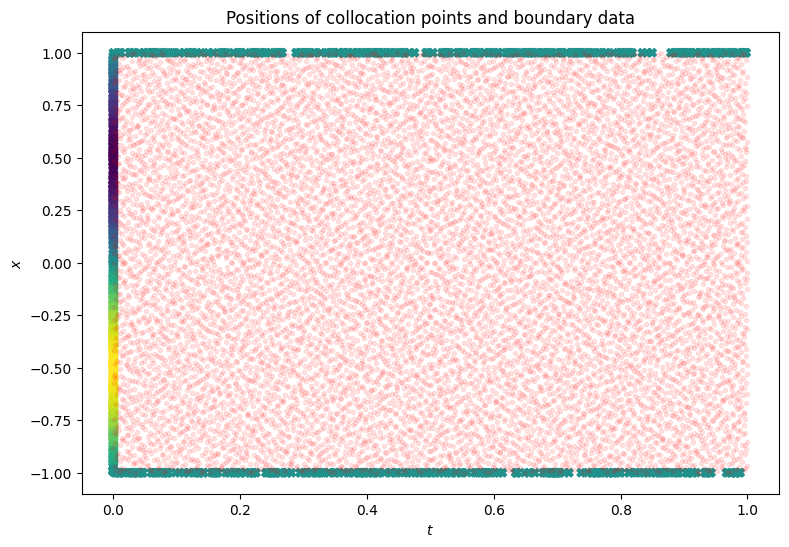

In [9]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

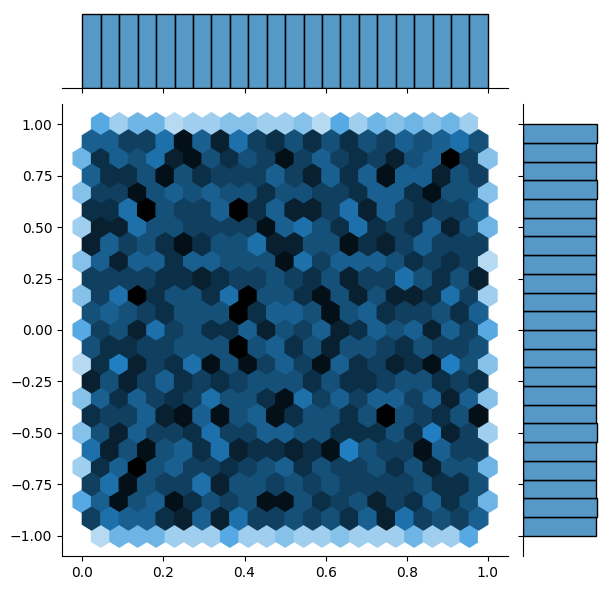

In [10]:
sns.jointplot(
    x=t_r.detach().numpy().flatten(), 
    y=x_r.detach().numpy().flatten(),
    kind="hex",
    
)

plt.show()

# PINN

In [11]:
# Set training parameters
max_epoch = 10000
base_pinn = PINN(
    input_dim=2,
    output_dim=1,
    hidden_layers= 9 * [42], 
    equation=burgers_1d
).to("cpu")
optimizers = {
    "model": optim.Adam(base_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [12]:
train_loss, eval_losses = train_pinn(
    max_epoch, 
    base_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device="cpu",
    random_resample_every_N=1000, lb=lb, ub=ub,
    calc_distinct_losses=True, 
    show_distinct_losses=True,
    sampler_type="sobol"
)

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Epoch: 50/10000, PINN Loss: 0.31471	physics_loss: 0.00584	boundary_loss: 0.08886	initial_loss: 0.21638	total_loss: 0.31109	
Epoch: 100/10000, PINN Loss: 0.17691	physics_loss: 0.05941	boundary_loss: 0.01169	initial_loss: 0.09600	total_loss: 0.16710	
Epoch: 150/10000, PINN Loss: 0.14867	physics_loss: 0.05645	boundary_loss: 0.00938	initial_loss: 0.08277	total_loss: 0.14860	
Epoch: 200/10000, PINN Loss: 0.14261	physics_loss: 0.05327	boundary_loss: 0.00789	initial_loss: 0.08129	total_loss: 0.14245	
Epoch: 250/10000, PINN Loss: 0.13215	physics_loss: 0.05044	boundary_loss: 0.00629	initial_loss: 0.07519	total_loss: 0.13192	
Epoch: 300/10000, PINN Loss: 0.12164	physics_loss: 0.04736	boundary_loss: 0.00494	initial_loss: 0.06916	total_loss: 0.12146	
Epoch: 350/10000, PINN Loss: 0.11183	physics_loss: 0.04377	boundary_loss: 0.00403	initial_loss: 0.06378	total_loss: 0.11159	
Epoch: 400/10000, PINN Loss: 0.10236	physics_loss: 0.03955	boundary_loss: 0.00227	initial_loss: 0.05831	total_loss: 0.10013	
E

In [13]:
# Set up meshgrid
base_pinn.to("cpu")
torch.cuda.empty_cache()
N = 501
T, X, U = compute_approximation_2d(base_pinn, lb, ub, N)

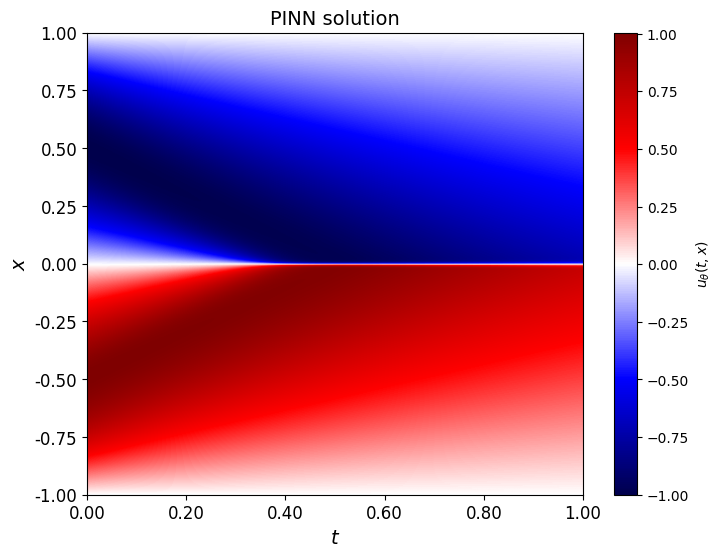

In [14]:
plot_single_heatmap_2d(T, X, U, title="PINN solution")

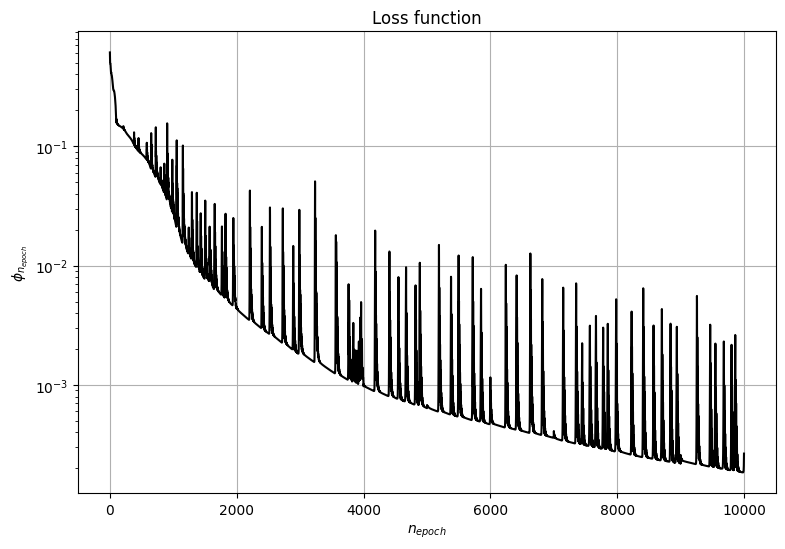

In [15]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), [loss["total_loss"] for loss in eval_losses],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [16]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "pinn.json") )
save_model(base_pinn, os.path.join("..", "saved_models", "1d_burgers", "pinn.pt"))

# RFF-PINN

In [17]:
# Set training parameters
max_epoch = 10000
rff_pinn = PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [18]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub,
    calc_distinct_losses=True, show_distinct_losses=True
)

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.23435	physics_loss: 0.03657	boundary_loss: 0.04315	initial_loss: 0.15106	total_loss: 0.23078	
Epoch: 100/10000, PINN Loss: 0.17975	physics_loss: 0.05758	boundary_loss: 0.00785	initial_loss: 0.11127	total_loss: 0.17670	
Epoch: 150/10000, PINN Loss: 0.15070	physics_loss: 0.06128	boundary_loss: 0.00411	initial_loss: 0.08525	total_loss: 0.15064	
Epoch: 200/10000, PINN Loss: 0.14673	physics_loss: 0.06236	boundary_loss: 0.00287	initial_loss: 0.08138	total_loss: 0.14661	
Epoch: 250/10000, PINN Loss: 0.13151	physics_loss: 0.05469	boundary_loss: 0.00146	initial_loss: 0.07504	total_loss: 0.13118	
Epoch: 300/10000, PINN Loss: 0.11701	physics_loss: 0.04231	boundary_loss: 0.00110	initial_loss: 0.07312	total_loss: 0.11653	
Epoch: 350/10000, PINN Loss: 0.09241	physics_loss: 0.03220	boundary_loss: 0.00071	initial_loss: 0.05863	total_loss: 0.09154	
Epoch: 400/10000, PINN Loss: 0.08162	physics_loss: 0.03088	boundary_loss: 0.00095	initial_loss: 0.04714	total_loss: 0.07897	
E

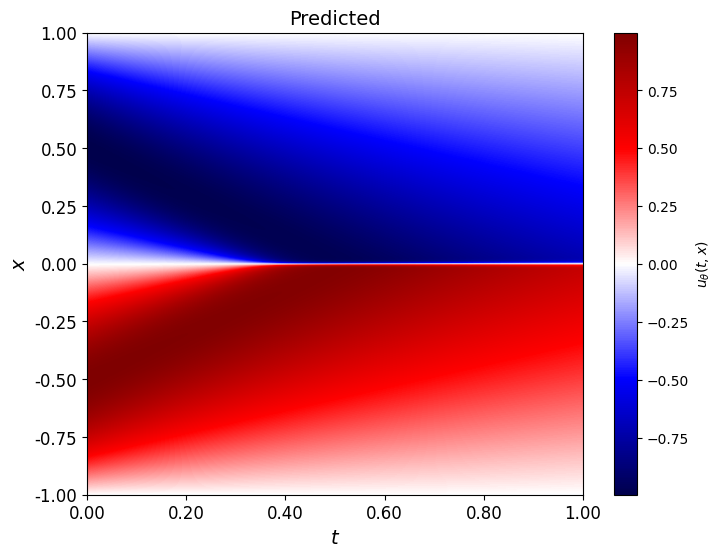

In [19]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

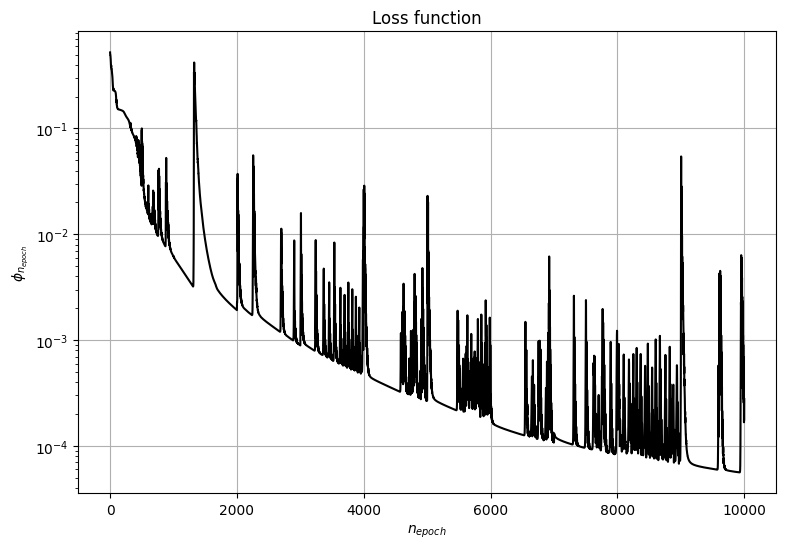

In [21]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), [loss["total_loss"] for loss in eval_losses],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [22]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "rff_pinn.json"))
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "rff_pinn.pt"))

# SA-PINN + RFF

In [ ]:
# Set training parameters
max_epoch = 10000
sa_pinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    activation=torch.nn.Tanh(),
    hidden_layers= 9 * [42],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizer = torch.optim.Adam(sa_pinn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)
optimizers = {
    "model": optim.Adam(sa_pinn.u_model.parameters(), lr=1e-4),
    "lambdas_pde": optim.Adam([sa_pinn.lambdas_pde], lr=1e-2),
    "lambdas_ics": optim.Adam([sa_pinn.lambdas_ics], lr=1e-2),
    "lambdas_bcs": optim.Adam([sa_pinn.lambdas_bcs], lr=1e-2)
}   
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9)
}

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [24]:
sa_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    sa_pinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    calc_distinct_losses=True, 
    show_distinct_losses=True,
)

Epoch: 50/10000, PINN Loss: 0.49711	physics_loss: 0.00003	boundary_loss: 0.00353	initial_loss: 0.49240	total_loss: 0.49596	
Epoch: 100/10000, PINN Loss: 0.42100	physics_loss: 0.00411	boundary_loss: 0.08545	initial_loss: 0.33133	total_loss: 0.42088	
Epoch: 150/10000, PINN Loss: 0.40622	physics_loss: 0.00410	boundary_loss: 0.07923	initial_loss: 0.32252	total_loss: 0.40585	
Epoch: 200/10000, PINN Loss: 0.37357	physics_loss: 0.00422	boundary_loss: 0.08410	initial_loss: 0.28416	total_loss: 0.37248	
Epoch: 250/10000, PINN Loss: 0.29833	physics_loss: 0.00990	boundary_loss: 0.07239	initial_loss: 0.21444	total_loss: 0.29673	
Epoch: 300/10000, PINN Loss: 0.24051	physics_loss: 0.03892	boundary_loss: 0.03219	initial_loss: 0.16814	total_loss: 0.23925	
Epoch: 350/10000, PINN Loss: 0.16747	physics_loss: 0.06249	boundary_loss: 0.00948	initial_loss: 0.09511	total_loss: 0.16708	
Epoch: 400/10000, PINN Loss: 0.15990	physics_loss: 0.06295	boundary_loss: 0.00833	initial_loss: 0.08853	total_loss: 0.15981	
E

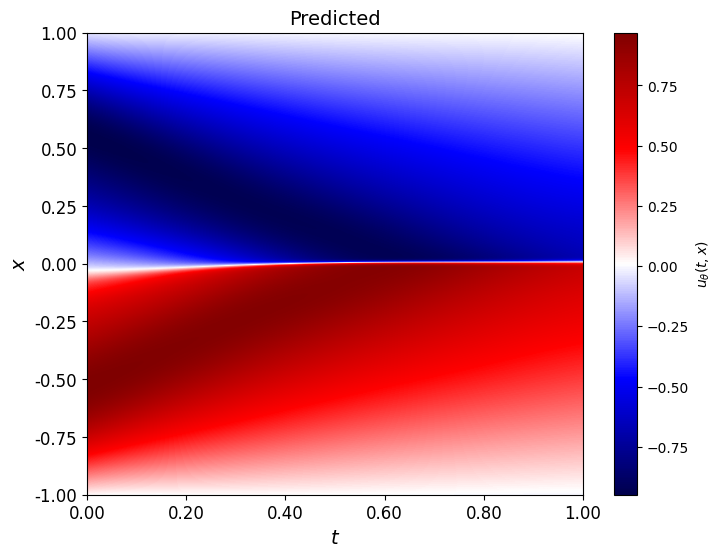

In [25]:
sa_pinn.to("cpu")
T, X, U = compute_approximation_2d(sa_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [26]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "sa_rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "sa_rff_pinn.json") )
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "sa_rff_pinn.pt"))

# DB-PINN + RFF

In [27]:
# Set training parameters
max_epoch = 10000
db_pinn = DB_PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(db_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [28]:
# db_pinn.loss_fn = PINN_Loss(equation=burgers_1d, u_model=db_pinn.u_model)

In [29]:
db_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    db_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub,
    sampler_type="sobol",
    calc_distinct_losses=True, 
    show_distinct_losses=True,
)

Epoch: 50/10000, PINN Loss: 0.63868	physics_loss: 0.04800	boundary_loss: 0.05150	initial_loss: 0.15177	total_loss: 0.25127	
Epoch: 100/10000, PINN Loss: 0.35446	physics_loss: 0.21807	boundary_loss: 0.00502	initial_loss: 0.01840	total_loss: 0.24149	
Epoch: 150/10000, PINN Loss: 0.33976	physics_loss: 0.24219	boundary_loss: 0.00224	initial_loss: 0.01164	total_loss: 0.25607	
Epoch: 200/10000, PINN Loss: 0.31245	physics_loss: 0.23791	boundary_loss: 0.00082	initial_loss: 0.00865	total_loss: 0.24738	
Epoch: 250/10000, PINN Loss: 0.29971	physics_loss: 0.23438	boundary_loss: 0.00076	initial_loss: 0.00691	total_loss: 0.24205	
Epoch: 300/10000, PINN Loss: 0.29967	physics_loss: 0.22498	boundary_loss: 0.00130	initial_loss: 0.00664	total_loss: 0.23292	
Epoch: 350/10000, PINN Loss: 0.27770	physics_loss: 0.22787	boundary_loss: 0.00032	initial_loss: 0.00498	total_loss: 0.23317	
Epoch: 400/10000, PINN Loss: 0.27185	physics_loss: 0.21818	boundary_loss: 0.00042	initial_loss: 0.00501	total_loss: 0.22361	


KeyboardInterrupt: 

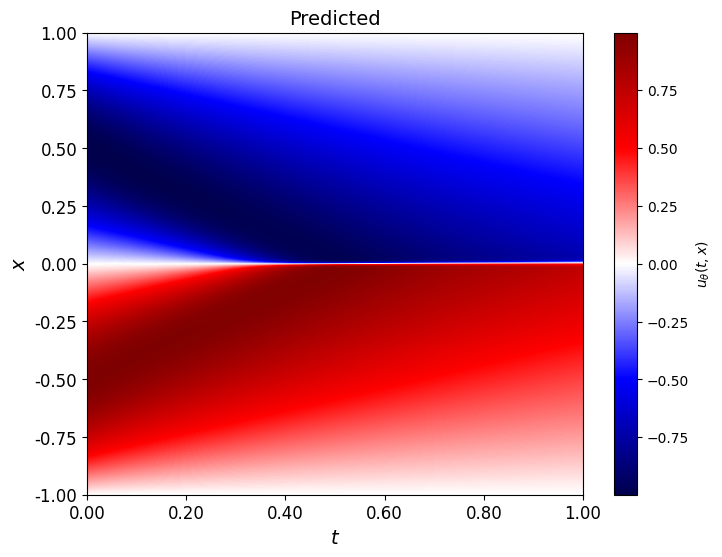

In [ ]:
N = 501
db_pinn.to("cpu")
T, X, U = compute_approximation_2d(db_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

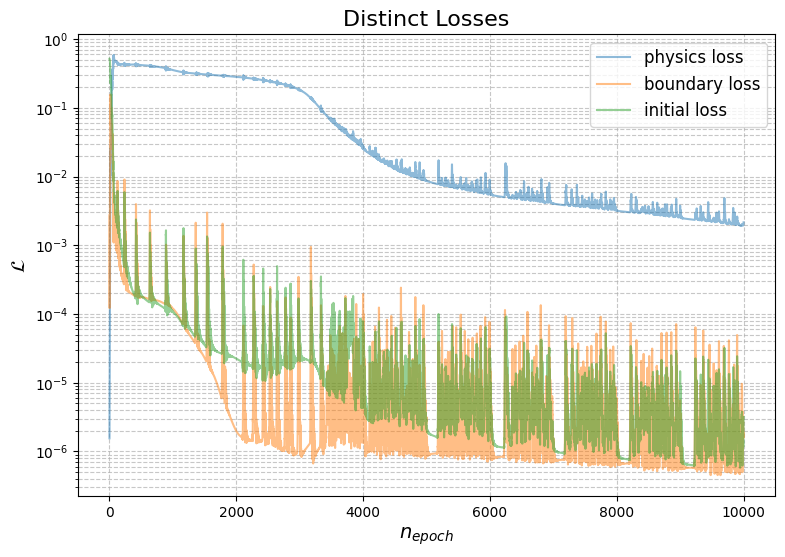

In [ ]:
physics_loss = [temp[1]["physics_loss"].item() for temp in eval_loss]
boundary_loss = [temp[1]["boundary_loss"].item() for temp in eval_loss]
initial_loss = [temp[1]["initial_loss"].item() for temp in eval_loss]
dist_losses = {
    "physics loss": physics_loss,
    "boundary loss": boundary_loss,
    "initial loss": initial_loss
}
# отрисовка сохраненных графиков
plot_loss(
    dist_losses, title="Distinct Losses", alpha=0.5,
    save_path=os.path.join("..", "pics", "1d_burgers", "loss", "db_pinn_distinct_losses.png")
)

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "db_rff_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "db_rff_pinn.json") )
save_model(db_pinn, os.path.join("..", "saved_models", "1d_burgers", "db_rff_pinn.pt"))

# PINN with DWA-Loss + RFF

In [35]:
# Set training parameters
max_epoch = 10000
dwa_pinn = BasePINN(
    input_dim=2,
    hidden_layers=9 * [42],
    loss_class=DWA_Loss,
    rff_features=20,
    output_dim=1,
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(dwa_pinn.u_model.parameters(), lr=1e-4),
    "lambdas_pde": optim.Adam([dwa_pinn.loss_fn.lambda_pde], lr=1e-2),
    "lambdas_ics": optim.Adam([dwa_pinn.loss_fn.lambda_ics], lr=1e-2),
    "lambdas_bcs": optim.Adam([dwa_pinn.loss_fn.lambda_bcs], lr=1e-2)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9)
}

In [37]:
dwa_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    dwa_pinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub,
    sampler_type="sobol",
    calc_distinct_losses=True, 
    show_distinct_losses=True,
)

Epoch: 50/10000, PINN Loss: 0.49521	physics_loss: 0.00001	boundary_loss: 0.00004	initial_loss: 0.49479	total_loss: 0.49484	
Epoch: 100/10000, PINN Loss: 0.43979	physics_loss: 0.00050	boundary_loss: 0.00661	initial_loss: 0.42973	total_loss: 0.43685	
Epoch: 150/10000, PINN Loss: 0.35003	physics_loss: 0.01153	boundary_loss: 0.06409	initial_loss: 0.27365	total_loss: 0.34927	
Epoch: 200/10000, PINN Loss: 0.27269	physics_loss: 0.03242	boundary_loss: 0.04110	initial_loss: 0.19607	total_loss: 0.26960	
Epoch: 250/10000, PINN Loss: 0.15812	physics_loss: 0.05918	boundary_loss: 0.00450	initial_loss: 0.09424	total_loss: 0.15792	
Epoch: 300/10000, PINN Loss: 0.15640	physics_loss: 0.05965	boundary_loss: 0.00545	initial_loss: 0.09129	total_loss: 0.15639	
Epoch: 350/10000, PINN Loss: 0.15608	physics_loss: 0.05973	boundary_loss: 0.00537	initial_loss: 0.09098	total_loss: 0.15608	
Epoch: 400/10000, PINN Loss: 0.15585	physics_loss: 0.05996	boundary_loss: 0.00525	initial_loss: 0.09063	total_loss: 0.15584	
E

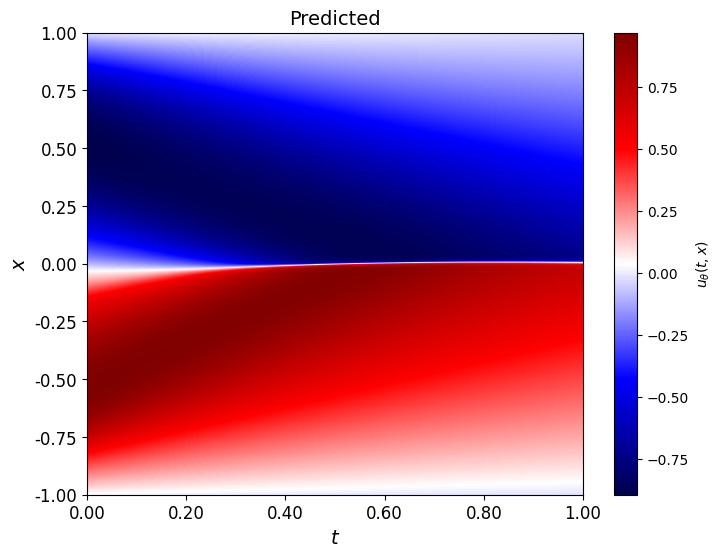

In [38]:
N = 501
dwa_pinn.to("cpu")
T, X, U = compute_approximation_2d(dwa_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

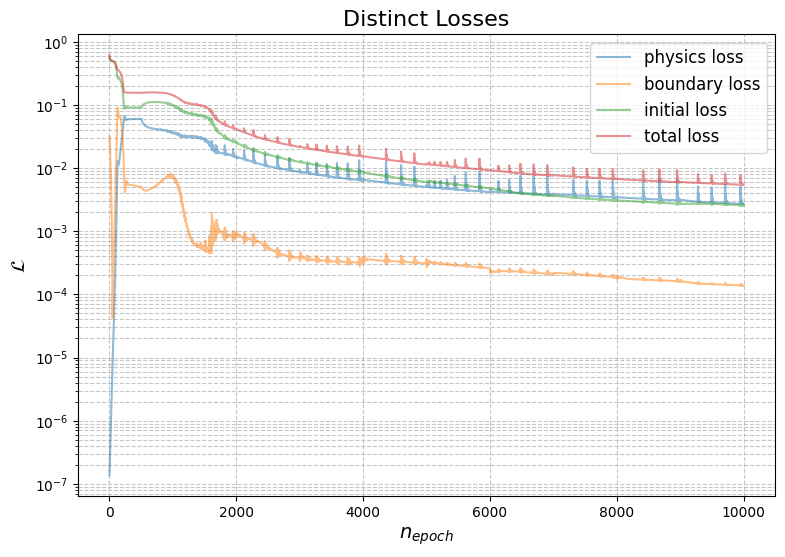

In [40]:
physics_loss = [temp["physics_loss"] for temp in eval_loss]
boundary_loss = [temp["boundary_loss"] for temp in eval_loss]
initial_loss = [temp["initial_loss"] for temp in eval_loss]
dist_losses = {
    "physics loss": physics_loss,
    "boundary loss": boundary_loss,
    "initial loss": initial_loss,
    "total loss": [physics_loss[i] + boundary_loss[i] + initial_loss[i] for i in range(len(physics_loss))]
}
# отрисовка сохраненных графиков
plot_loss(
    dist_losses, title="Distinct Losses", alpha=0.5,
    save_path=os.path.join("..", "pics", "1d_burgers", "loss", "dwa_pinn.png")
)

In [41]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "dwa_pinn.json"))
save_eval_losses(dist_losses["total loss"], os.path.join("..", "data", "loss", "dwa_pinn.json") )
save_model(dwa_pinn, os.path.join("..", "saved_models", "1d_burgers", "dwa_pinn.pt"))

# PirateNet PINN

In [42]:
# Set training parameters
max_epoch = 10000
piratenet_pinn = PirateNetPINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    num_blocks=3,
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(piratenet_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [44]:
piratenet_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    piratenet_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub,
    sampler_type="sobol",
    calc_distinct_losses=True, 
    show_distinct_losses=True,
)

Epoch: 50/10000, PINN Loss: 0.24013	physics_loss: 0.04819	boundary_loss: 0.02331	initial_loss: 0.15874	total_loss: 0.23024	
Epoch: 100/10000, PINN Loss: 0.14699	physics_loss: 0.05955	boundary_loss: 0.00353	initial_loss: 0.08356	total_loss: 0.14663	
Epoch: 150/10000, PINN Loss: 0.11725	physics_loss: 0.04710	boundary_loss: 0.00289	initial_loss: 0.06615	total_loss: 0.11614	
Epoch: 200/10000, PINN Loss: 0.06988	physics_loss: 0.03325	boundary_loss: 0.00020	initial_loss: 0.03722	total_loss: 0.07067	
Epoch: 250/10000, PINN Loss: 0.03644	physics_loss: 0.02548	boundary_loss: 0.00009	initial_loss: 0.01508	total_loss: 0.04065	
Epoch: 300/10000, PINN Loss: 0.02179	physics_loss: 0.00606	boundary_loss: 0.00003	initial_loss: 0.00600	total_loss: 0.01209	
Epoch: 350/10000, PINN Loss: 0.00710	physics_loss: 0.00365	boundary_loss: 0.00001	initial_loss: 0.00343	total_loss: 0.00710	
Epoch: 400/10000, PINN Loss: 0.00489	physics_loss: 0.00283	boundary_loss: 0.00001	initial_loss: 0.00227	total_loss: 0.00511	
E

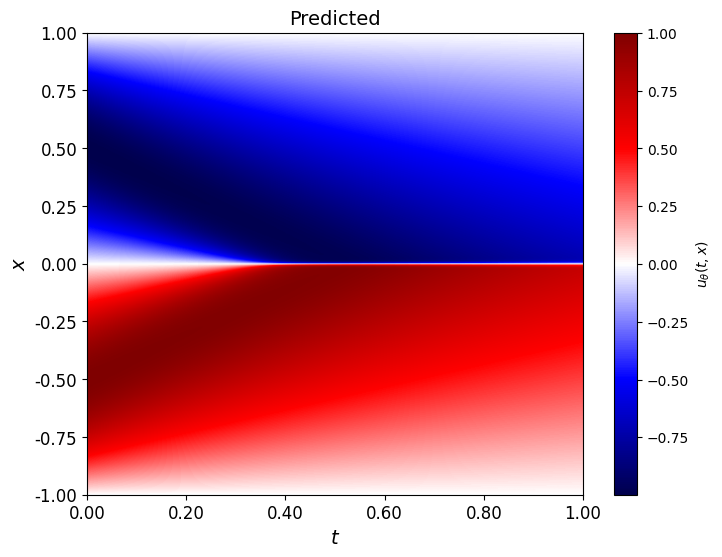

In [45]:
N = 501
piratenet_pinn.to("cpu")
T, X, U = compute_approximation_2d(piratenet_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

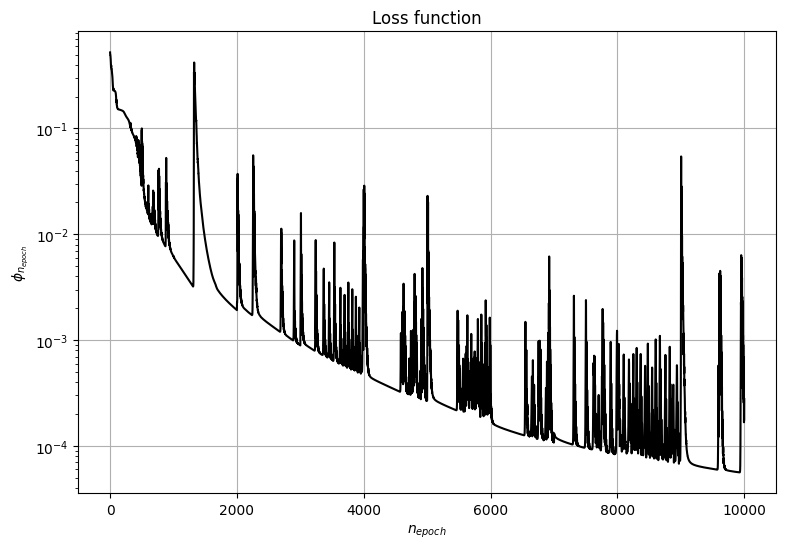

In [47]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_loss)), [loss["total_loss"] for loss in eval_losses],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [48]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "piratenet_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "piratenet_pinn.json") )
save_model(piratenet_pinn, os.path.join("..", "saved_models", "1d_burgers", "piratenet_pinn.pt"))

# PINN (ResNet) PINN

In [49]:
# Set training parameters
max_epoch = 10000
resnet_pinn = BasePINN(
    input_dim=2,
    hidden_layers=9 * [42],
    model_class=ResNet,
    loss_class=PINN_Loss,
    rff_features=20,
    output_dim=1,
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(resnet_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [51]:
resnet_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    resnet_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub,
    sampler_type="sobol",
    calc_distinct_losses=True, 
    show_distinct_losses=True,
)

Epoch: 50/10000, PINN Loss: 0.15180	physics_loss: 0.05517	boundary_loss: 0.00428	initial_loss: 0.09215	total_loss: 0.15160	
Epoch: 100/10000, PINN Loss: 0.14300	physics_loss: 0.05916	boundary_loss: 0.00399	initial_loss: 0.07963	total_loss: 0.14278	
Epoch: 150/10000, PINN Loss: 0.12525	physics_loss: 0.04961	boundary_loss: 0.00294	initial_loss: 0.07217	total_loss: 0.12472	
Epoch: 200/10000, PINN Loss: 0.10943	physics_loss: 0.05728	boundary_loss: 0.00437	initial_loss: 0.06279	total_loss: 0.12445	
Epoch: 250/10000, PINN Loss: 0.10361	physics_loss: 0.04495	boundary_loss: 0.00083	initial_loss: 0.05781	total_loss: 0.10359	
Epoch: 300/10000, PINN Loss: 0.09794	physics_loss: 0.04288	boundary_loss: 0.00065	initial_loss: 0.05428	total_loss: 0.09781	
Epoch: 350/10000, PINN Loss: 0.09097	physics_loss: 0.03947	boundary_loss: 0.00047	initial_loss: 0.05089	total_loss: 0.09082	
Epoch: 400/10000, PINN Loss: 0.09155	physics_loss: 0.03975	boundary_loss: 0.00088	initial_loss: 0.04573	total_loss: 0.08636	
E

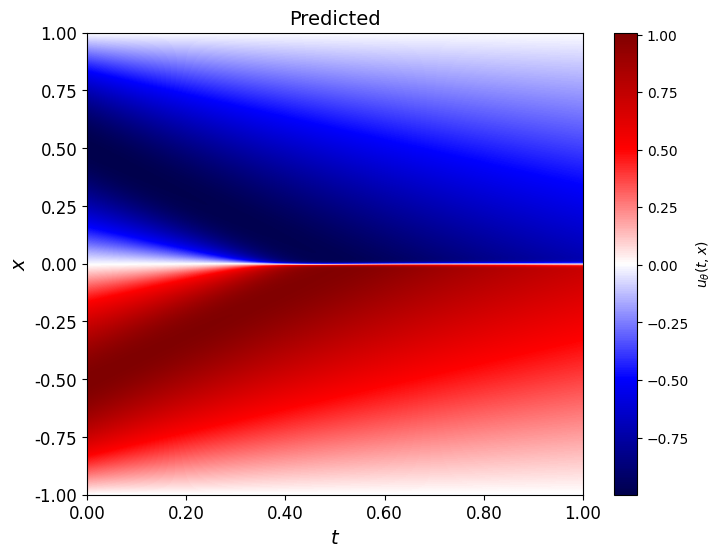

In [52]:
N = 501
resnet_pinn.to("cpu")
T, X, U = compute_approximation_2d(resnet_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

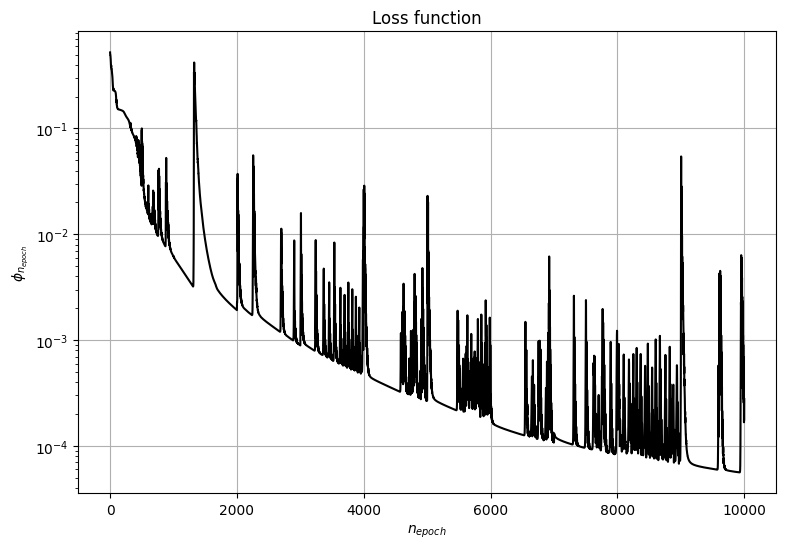

In [53]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_loss)), [loss["total_loss"] for loss in eval_losses],'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [54]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "resnet_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "resnet_pinn.json") )
save_model(resnet_pinn, os.path.join("..", "saved_models", "1d_burgers", "resnet_pinn.pt"))

# Analytic solution

In [ ]:
correct = burgers_1d.analytical_solution(T, X)
plot_single_heatmap_2d(T, X, correct, title="Analytical") 

KeyboardInterrupt: 

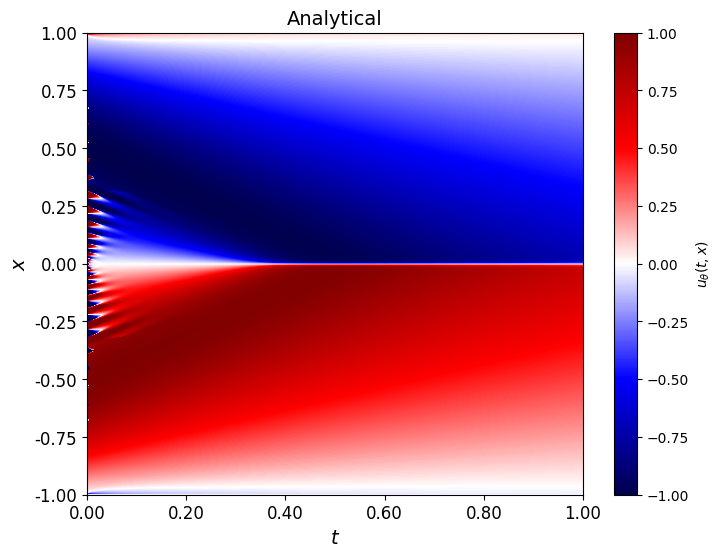

In [ ]:
plot_single_heatmap_2d(
    T, X, correct.clip(min=-1, max=1, out=correct), 
    title="Analytical"
) 

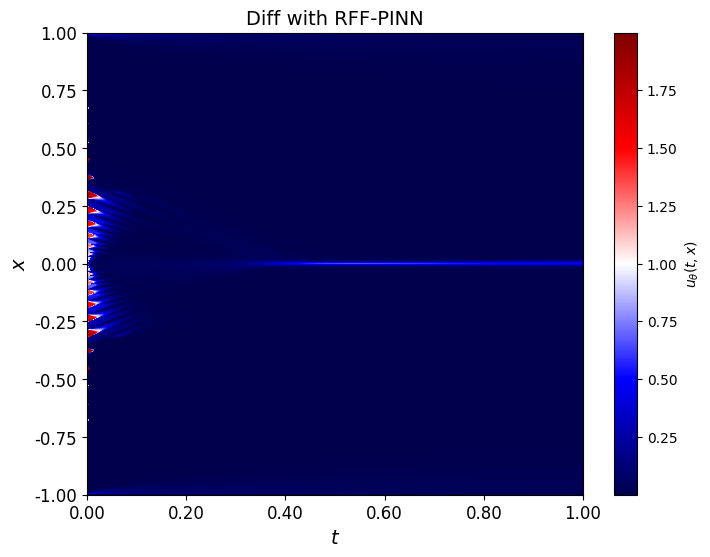

In [ ]:
with open(os.path.join("..", "data", "results", "rff_pinn.json")) as f:
    data = json.load(f)
plot_single_heatmap_2d(
    T, X, np.abs(data["u_map"] - correct.clip(min=-1, max=1, out=correct)), 
    title="Diff with RFF-PINN"
) 

# Comparasion

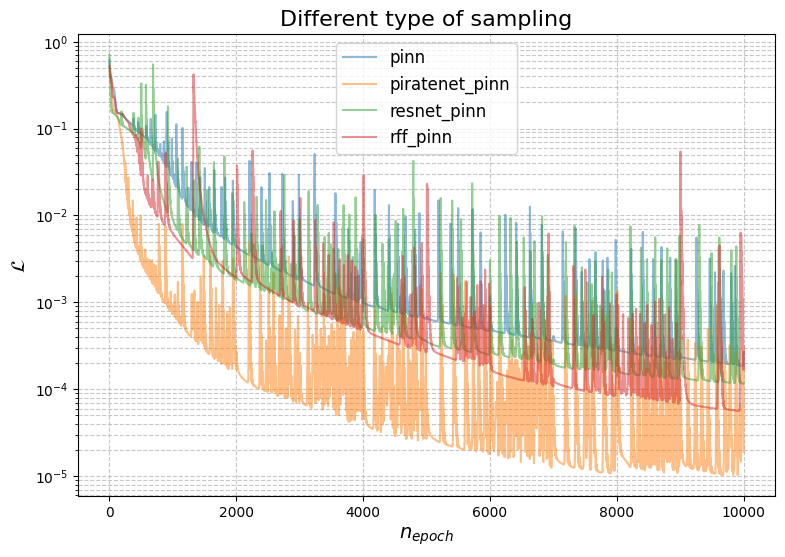

In [63]:
import json
# отрисовка сохраненных графиков
mask_path = [filename.split(".")[0] for filename in os.listdir(os.path.join("..", "data", "model_selection", "loss")) if filename.endswith(".json")]
losses = dict(zip(mask_path, [None] * len(mask_path)))
for mask in mask_path:
    with open(os.path.join("..", "data", "model_selection", "loss",  f"{mask}.json")) as f:
        data = json.load(f)
    losses[mask] = [losses["total_loss"] for losses in data]
plot_loss(
    losses, title="Different type of sampling", alpha=0.5
    # save_path=os.path.join("..", "pics", "1d_burgers", "loss", "rff_pinn_v001divpi.png")
)